# **Rag From Scratch: Query Transformations**

In [18]:
! pip install langchain_community tiktoken langchain-huggingface langchainhub chromadb langchain langchain_groq

In [19]:
import os
from google.colab import userdata
from uuid import uuid4

unique_id = uuid4()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["USER_AGENT"] = "myagent"

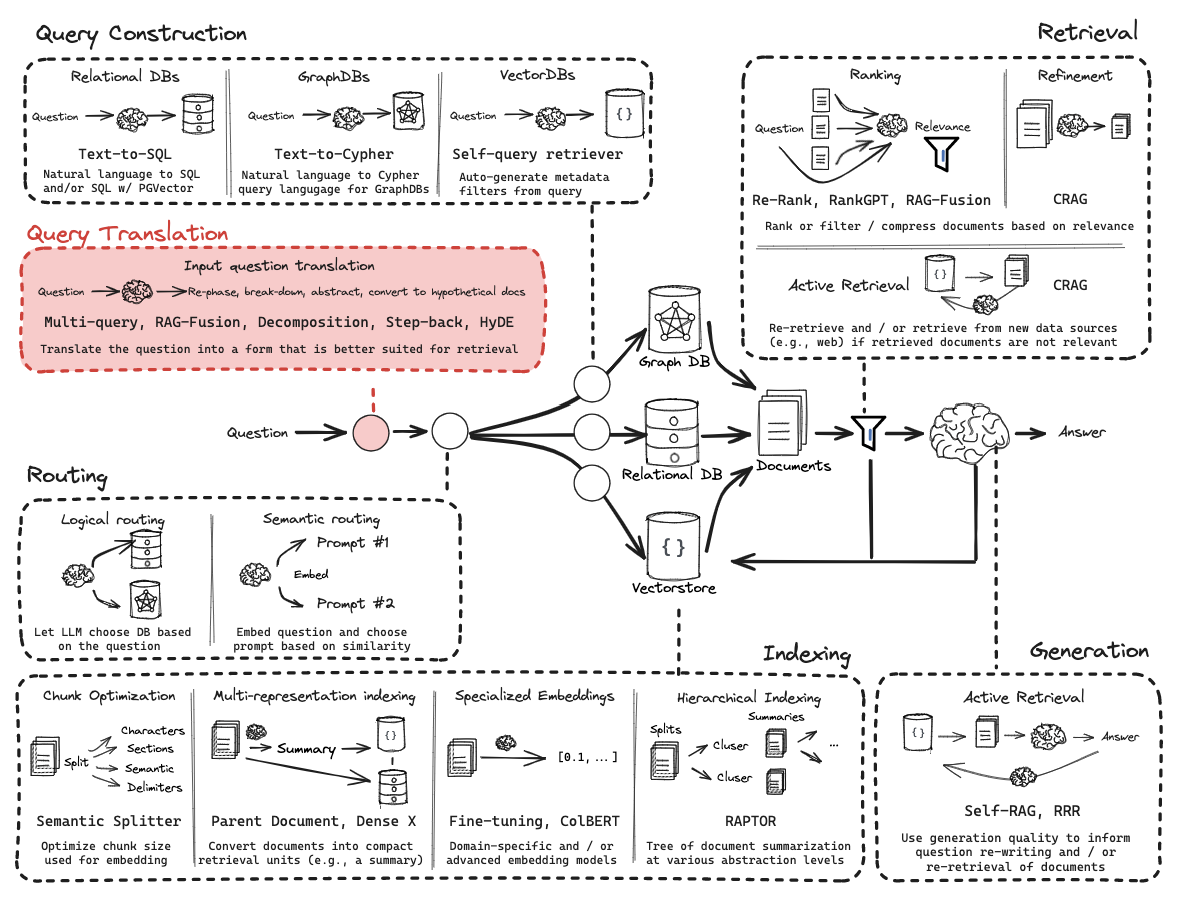

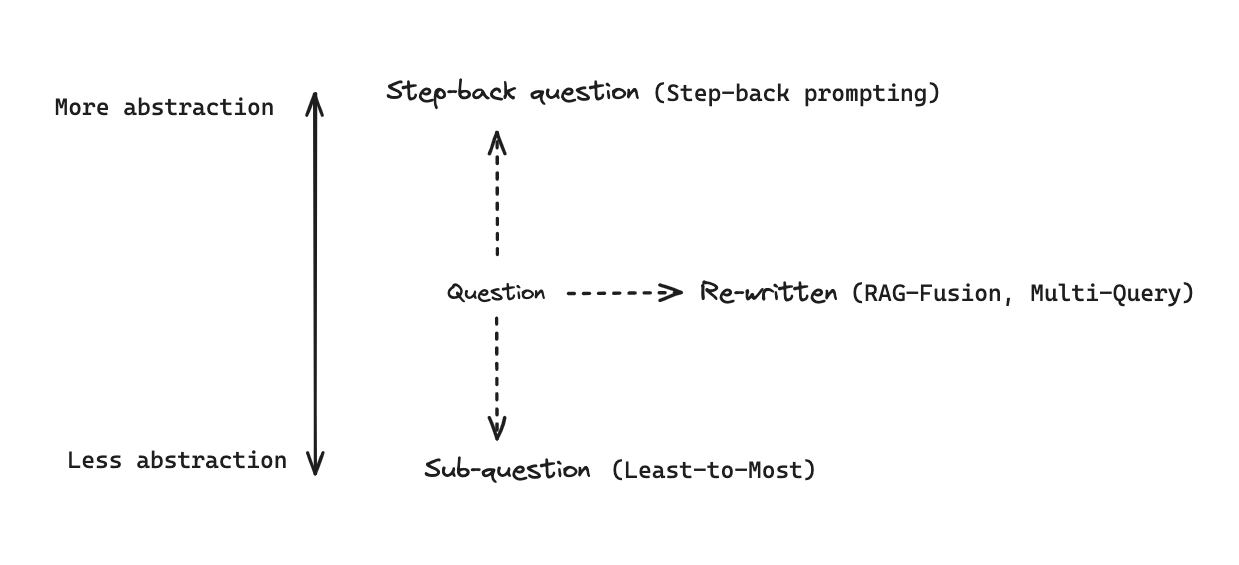

## Part 5: Multi Query

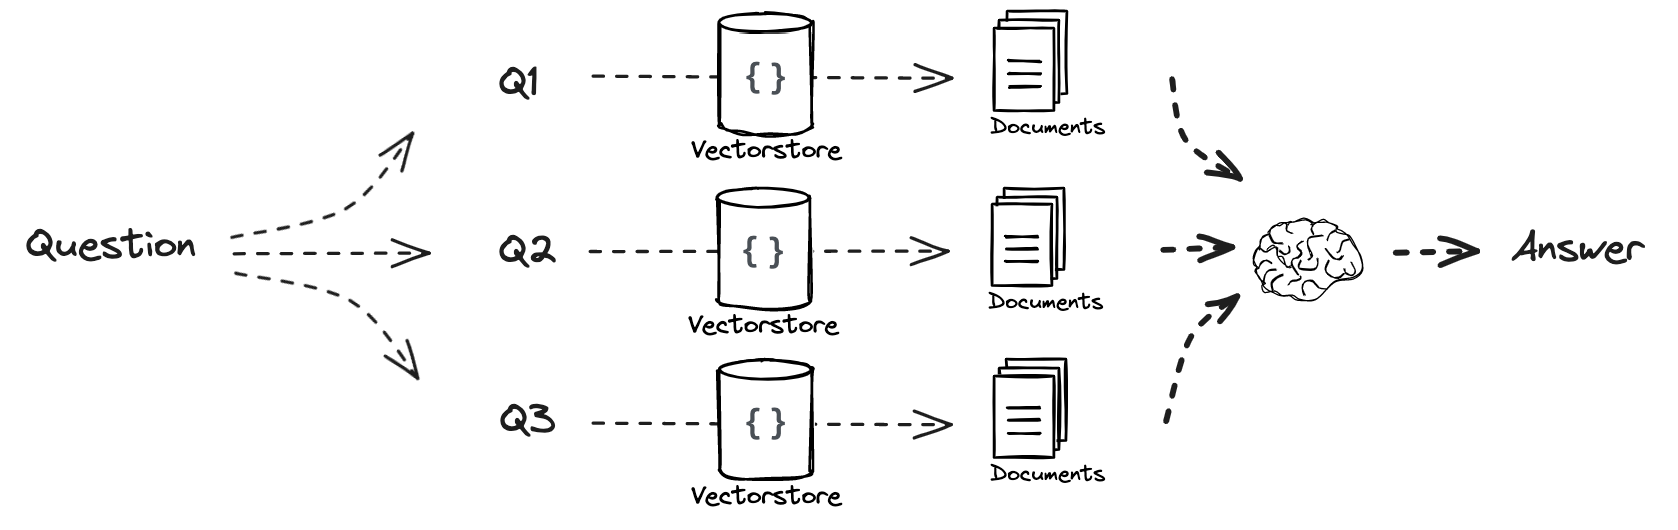

### Index

In [20]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

retriever = vectorstore.as_retriever()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Prompt

In [44]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines, without other prompts. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

generate_queries = (
    prompt_perspectives
    | ChatGroq(model="llama3-8b-8192", temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n\n"))
)

generate_queries.invoke({"question":"What is task decomposition for LLM agents?"})

['What are the key components of task decomposition in large language model (LLM) agents?',
 'How do LLM agents break down complex tasks into smaller, manageable subtasks?',
 'What strategies do LLM agents use to decompose tasks and improve their performance?',
 'Can you provide examples of task decomposition in LLM agents and how they achieve it?',
 'What are the benefits and limitations of task decomposition in LLM agents, and how do they impact their overall performance?']

In [62]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

3

In [49]:
from operator import itemgetter
from langchain_groq import ChatGroq
from langchain_core.runnables import RunnablePassthrough
from IPython.display import Markdown

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatGroq(model="llama3-8b-8192", temperature=0)

final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

Markdown(final_rag_chain.invoke({"question":question}))

According to the text, task decomposition for LLM (Large Language Model) agents involves breaking down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. This can be achieved through various methods, including:

1. Chain of Thought (CoT) prompting technique, which instructs the model to "think step by step" to decompose hard tasks into smaller and simpler steps.
2. Tree of Thoughts (Yao et al. 2023), which extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure.
3. Simple prompting, such as "Steps for XYZ.\n1." or "What are the subgoals for achieving XYZ?"
4. Task-specific instructions, such as "Write a story outline." for writing a novel.
5. Human inputs.

## Part 6: RAG-Fusion

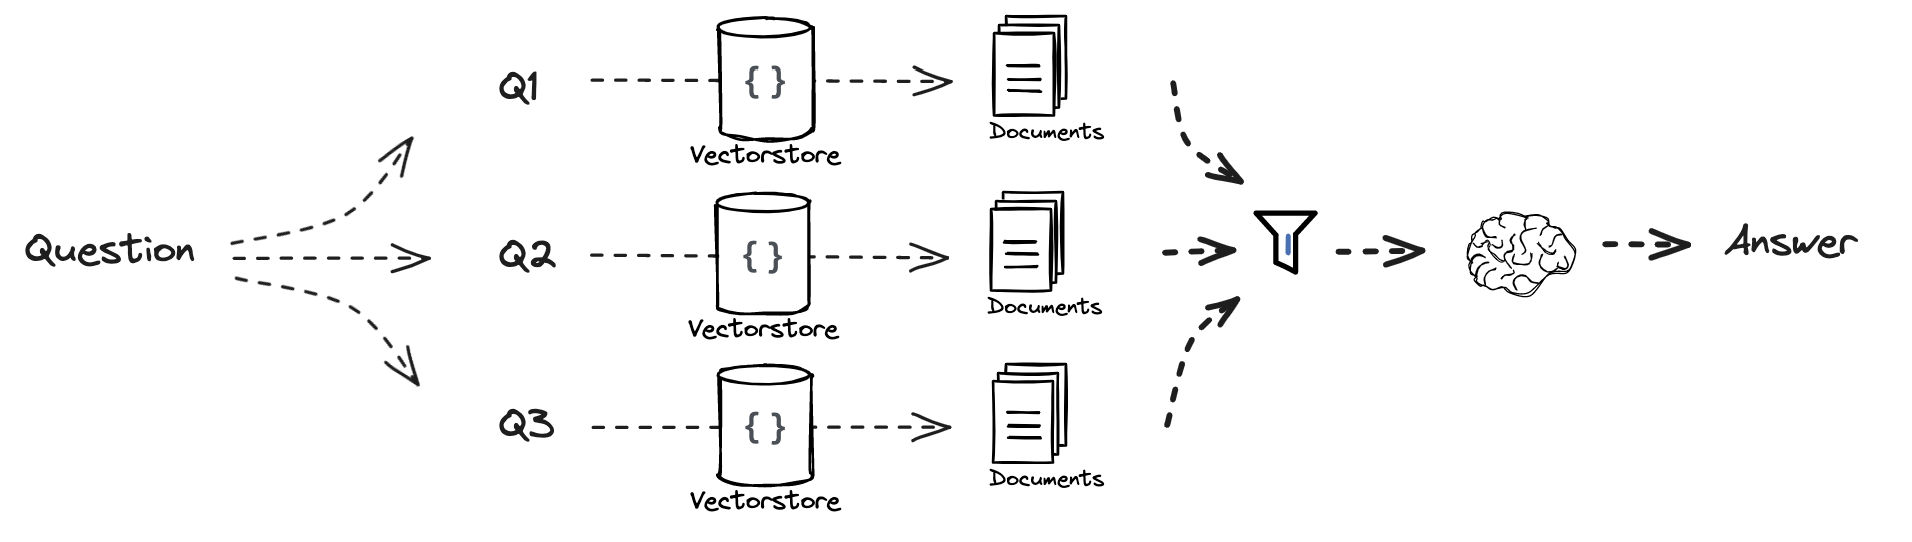

In [50]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [53]:
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

generate_queries = (
    prompt_perspectives
    | ChatGroq(model="llama3-8b-8192", temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n\n"))
)

generate_queries.invoke({"question":"What is task decomposition for LLM agents?"})

['What are the key components of task decomposition in large language model (LLM) agents?',
 'How do LLM agents break down complex tasks into smaller, manageable subtasks?',
 'What strategies do LLM agents use to decompose tasks and improve their performance?',
 'Can you provide examples of task decomposition in LLM agents and how they achieve it?',
 'What are the benefits and limitations of task decomposition in LLM agents, and how do they impact their overall performance?']

In [54]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

3

In [56]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

Markdown(final_rag_chain.invoke({"question":question}))

According to the provided context, task decomposition for LLM (Large Language Model) agents is the process of breaking down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. This is achieved through various techniques, including:

1. Chain of Thought (CoT): instructing the model to "think step by step" to decompose hard tasks into smaller and simpler steps.
2. Tree of Thoughts (Yao et al. 2023): extending CoT by exploring multiple reasoning possibilities at each step, creating a tree structure.
3. Simple prompting: using prompts like "Steps for XYZ.\n1." or "What are the subgoals for achieving XYZ?" to guide the model.
4. Task-specific instructions: using instructions specific to the task, such as "Write a story outline." for writing a novel.
5. Human inputs: incorporating human inputs to aid in task decomposition.

## Part 7: Decomposition

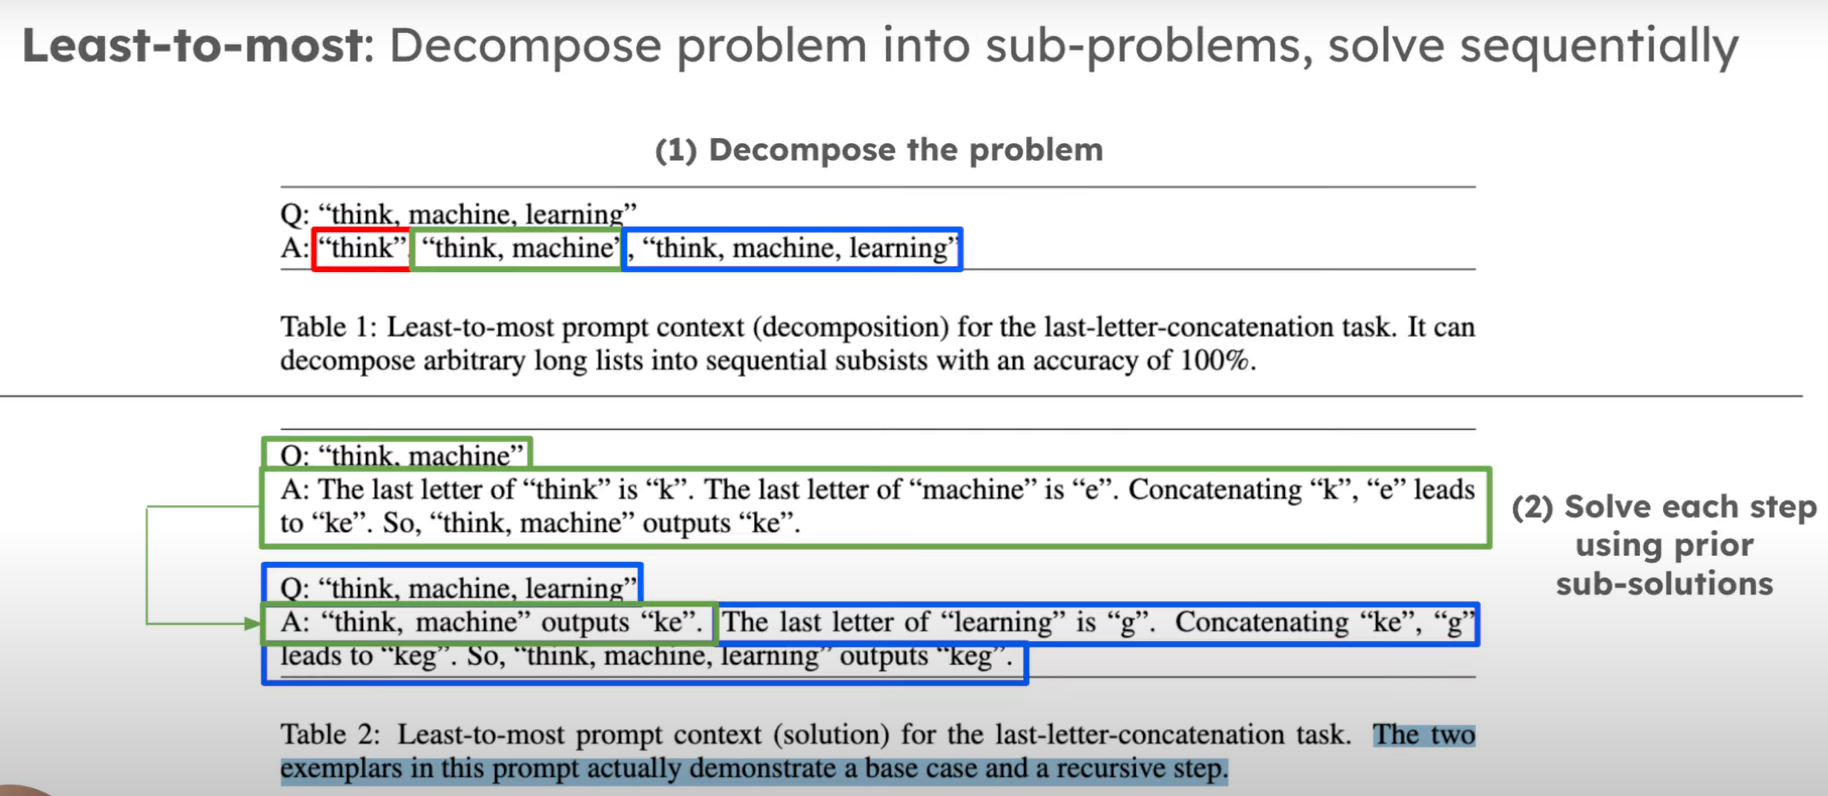

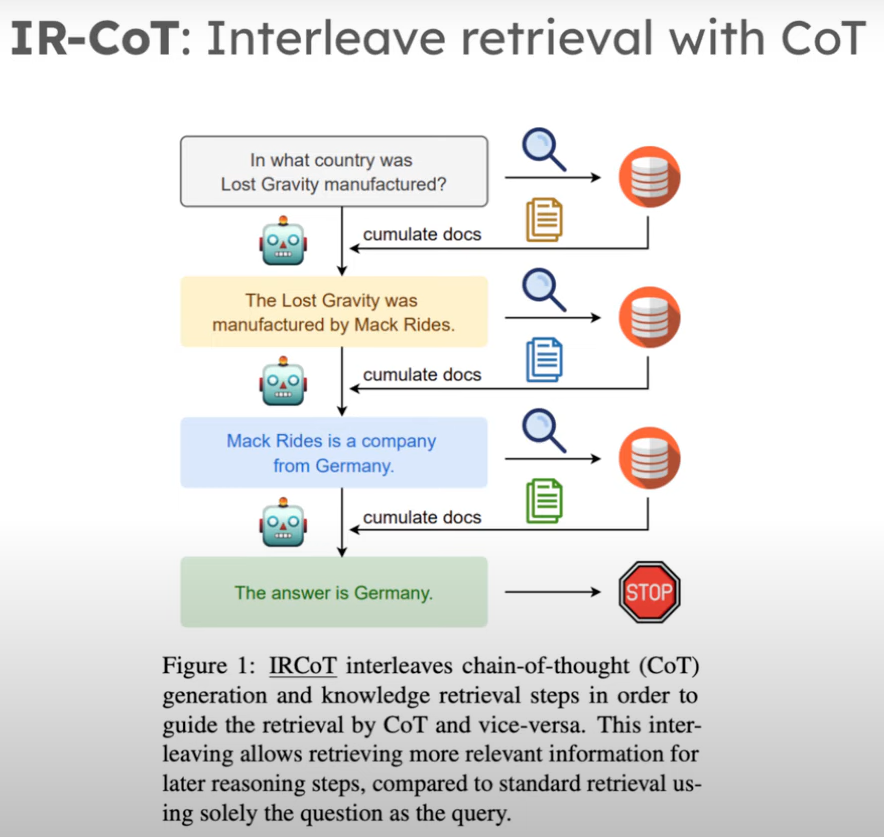

In [100]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate the multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [107]:
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)
# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})
questions

['1. "Main components of a language model in autonomous agent systems"',
 '2. "Role of natural language understanding in LLM-powered autonomous agents"',
 '3. "How does natural language generation contribute to autonomous agent systems"']

### Answer recursively

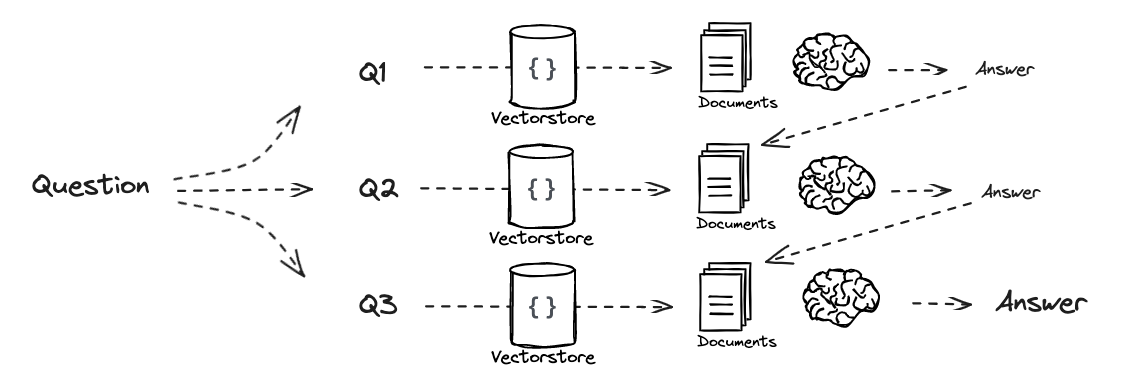

In [102]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [103]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)

q_a_pairs = ""
for q in questions:

    rag_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")}
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [108]:
Markdown(answer)

Natural language generation (NLG) is a crucial component of autonomous agent systems as it enables the system to generate human-like language and communicate effectively with users. In the context of LLM-powered autonomous agents, the language model at the core of the system functions as the agent's brain, and its primary function is to process and understand natural language inputs, as well as generate appropriate responses or actions.

NLG is responsible for generating natural language outputs based on the system's internal decision-making processes. This includes generating responses to user queries, formulating plans and strategies, and providing explanations for its actions. By generating natural language outputs, the autonomous agent system can interact with users and external components in a human-like manner, making it more accessible and user-friendly.

Moreover, NLG can help autonomous agent systems to handle complex tasks by breaking them down into smaller, manageable subgoals and generating natural language descriptions of these subgoals. This enables the system to plan and execute complex tasks more efficiently, while also providing users with clear and concise explanations of the system's decision-making processes.

In the proof-of-concept example of AutoGPT, the system message provides the LLM with context and instructions for its decision-making process, including the AI's name, a user-provided description of the AI, and a list of user-provided goals. The LLM then uses NLG to generate appropriate responses or actions based on this information.

However, NLG in autonomous agent systems also faces unique challenges and limitations, such as finite context length, challenges in long-term planning and task decomposition, and the reliability of the natural language interface. These challenges can affect the system's ability to generate accurate and reliable natural language outputs, and may require additional mechanisms and techniques to overcome.

Overall, NLG is a critical component of autonomous agent systems, enabling the system to generate human-like language and communicate effectively with users. By handling the unique challenges and limitations of working with a language model, NLG can help autonomous agent systems to process natural language inputs, make decisions, and take actions independently, while also improving the quality of final results.

### Answer individually

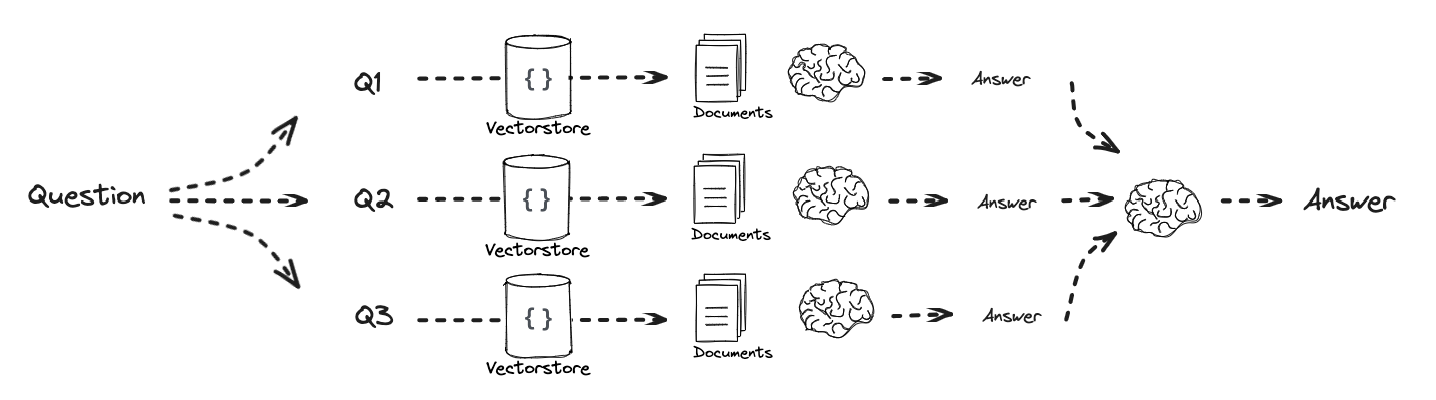

In [114]:
# Answer each sub-question individually

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""

    # Use our decomposition /
    sub_questions = sub_question_generator_chain.invoke({"question":question})

    # Initialize a list to hold RAG chain results
    rag_results = []

    for sub_question in sub_questions:

        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)

        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs,
                                                                "question": sub_question})
        rag_results.append(answer)

    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [117]:
questions

['1. "Main components of a language model in autonomous agent systems"',
 '2. "Role of natural language understanding in LLM-powered autonomous agents"',
 '3. "How does natural language generation contribute to autonomous agent systems"']

In [116]:
answers

['The main components of a language model in autonomous agent systems include the language model itself, which is the primary controller, and the natural language interface, which enables communication between the language model and external components. The system message and goals are also important components, providing instructions and objectives for the language model to follow.',
 "In a LLM-powered autonomous agent, natural language understanding plays a crucial role as it enables the agent to function as a general problem solver. The language model, LLM, breaks down large tasks into manageable subgoals, reflects on past actions for self-improvement, and can be framed as the agent's brain.",
 'Natural language generation contributes to autonomous agent systems by enabling emergent social behavior, such as information diffusion, relationship memory, and coordination of social events. In the context of AutoGPT, a proof-of-concept autonomous agent, natural language generation is used

In [118]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""

    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

Markdown(final_rag_chain.invoke({"context":context,"question":question}))

The main components of an LLM-powered autonomous agent system include the large language model (LLM) itself, which serves as the primary controller, and the natural language interface, which facilitates communication between the LLM and external components. The system message and goals are also crucial components, as they provide instructions and objectives for the LLM to follow. Natural language understanding plays a significant role in this type of system, enabling the agent to function as a general problem solver by breaking down large tasks into manageable subgoals, reflecting on past actions for self-improvement, and being framed as the agent's brain. Additionally, natural language generation contributes to the system by enabling emergent social behavior, such as information diffusion, relationship memory, and coordination of social events. However, it is important to note that there may be reliability issues with the natural language interface, such as formatting errors and occasional rebellious behavior.

## Part 8: Step Back

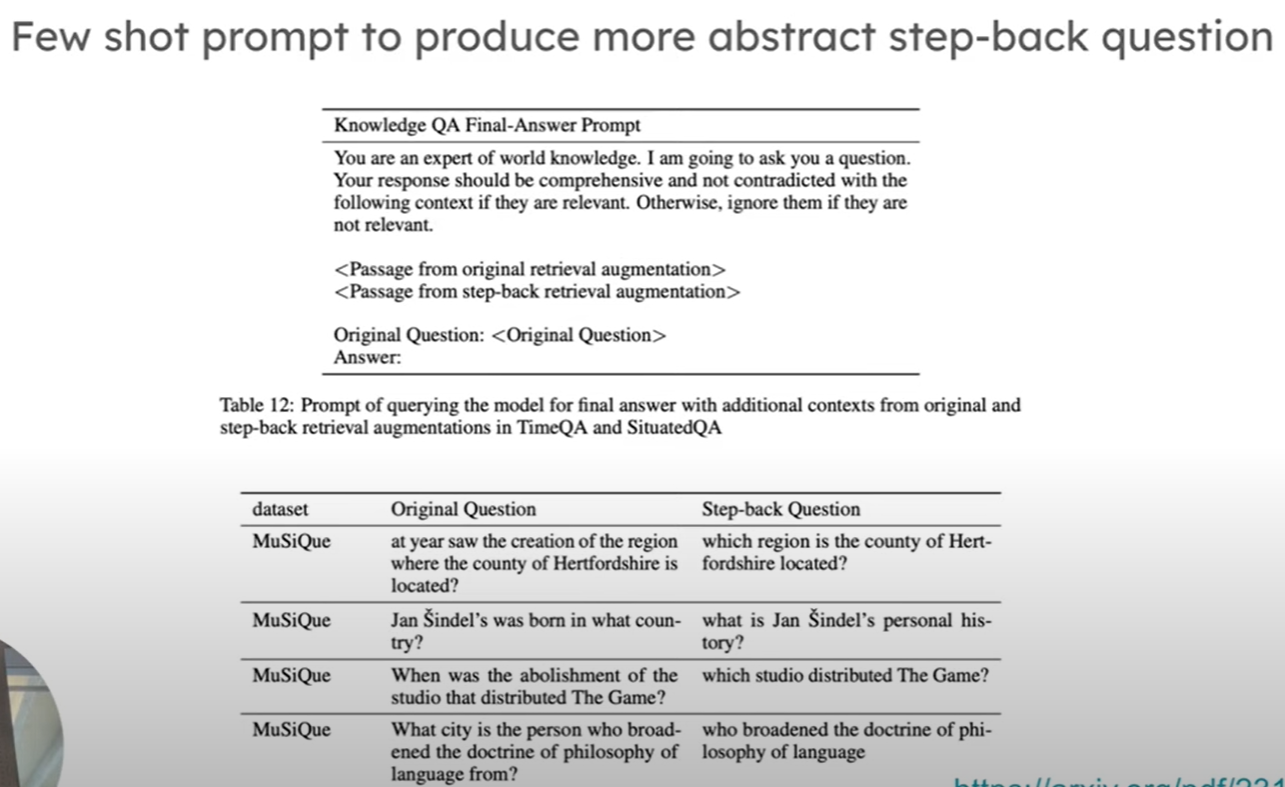

In [119]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [124]:
generate_queries_step_back = prompt | llm | StrOutputParser()
question = "What is task decomposition for LLM agents?"
Markdown(generate_queries_step_back.invoke({"question": question}))

how is a large language model agent's task broken down into smaller parts? or what are the steps involved in completing a task for a large language model agent?

In [123]:
# Response prompt
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

Markdown(chain.invoke({"question": question}))

Task decomposition for LLM (large language model) agents refers to the process of breaking down complex tasks into smaller, manageable subgoals. This allows the agent to handle complex tasks more efficiently. There are different methods for task decomposition, such as using simple prompting techniques like "Steps for XYZ" or "What are the subgoals for achieving XYZ?", using task-specific instructions, or involving human inputs.

Chain of Thought (CoT) and Tree of Thoughts (ToT) are two techniques that enhance model performance on complex tasks by decomposing them into smaller and simpler steps. CoT instructs the model to "think step by step" and transform big tasks into multiple manageable tasks, shedding light on the model's thinking process. ToT extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure with each state evaluated by a classifier or majority vote.

Task decomposition is a crucial component of a LLM-powered autonomous agent system, as it enables the agent to plan and manage complex tasks effectively. However, there are challenges in long-term planning and task decomposition, such as planning over a lengthy history and effectively exploring the solution space. Additionally, the reliability of the natural language interface between the LLM and external components like memory and tools can be questionable due to potential formatting errors and occasional rebellious behavior from the LLM.

## Part 9: HyDE

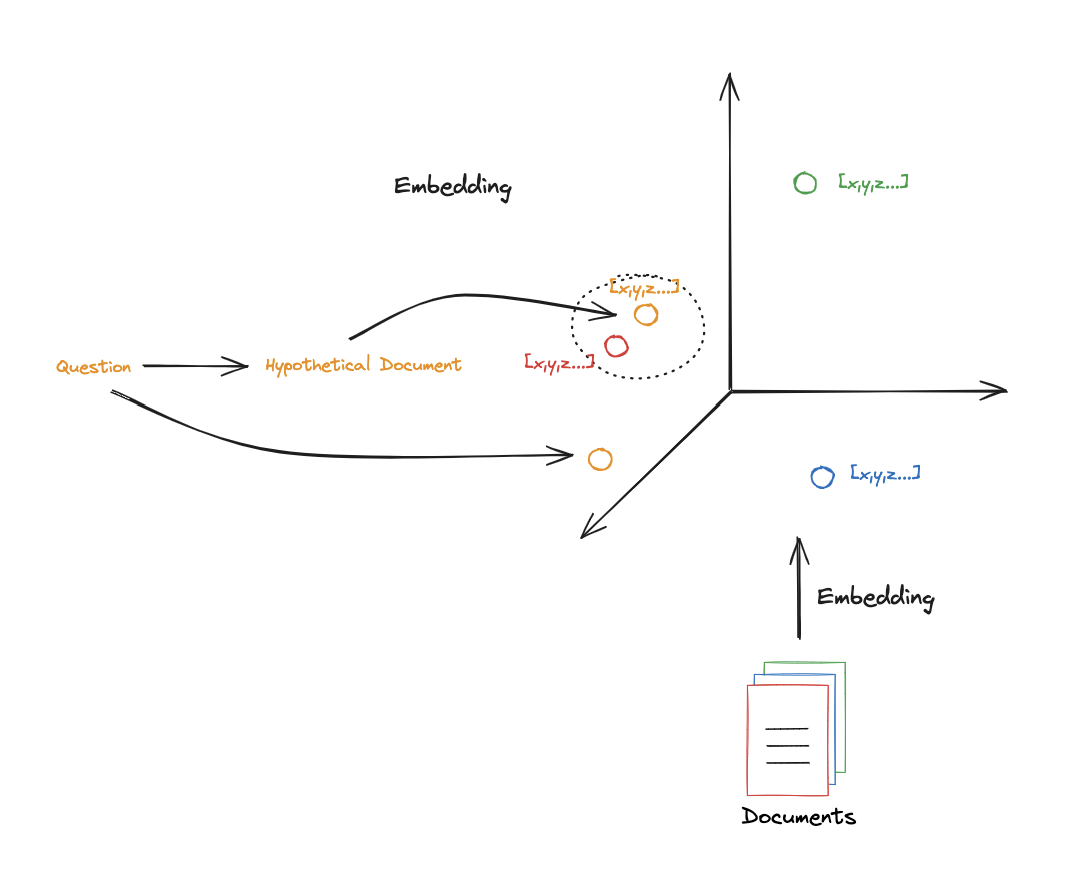

In [127]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | llm | StrOutputParser()
)

# Run
question = "What is task decomposition for LLM agents?"
Markdown(generate_docs_for_retrieval.invoke({"question":question}))

Task decomposition is a crucial aspect of building Large Language Model (LLM) agents that can effectively complete complex tasks. It involves breaking down a complex task into smaller, manageable subtasks that the LLM agent can handle more efficiently. This process is similar to the way humans approach complex problems by dividing them into smaller, more manageable parts.

In the context of LLM agents, task decomposition enables the agent to focus on one subtask at a time, reducing the cognitive load and increasing the likelihood of success. Each subtask is defined in a way that the LLM agent can understand and execute, often involving specific language commands or functions.

For example, consider a task where an LLM agent needs to summarize a research paper and answer questions about its content. Task decomposition for this scenario might involve the following subtasks:

1. Extract the main points from the research paper.
2. Generate a summary of the research paper based on the main points.
3. Identify the questions asked about the research paper.
4. Locate the relevant information in the research paper to answer each question.
5. Generate answers to the questions based on the relevant information.

By decomposing the task in this way, the LLM agent can focus on one subtask at a time, reducing the complexity of the overall task and increasing the chances of success. This approach also allows for more modular and scalable agent design, as new subtasks can be added or modified as needed.

In summary, task decomposition is the process of breaking down complex tasks into smaller, manageable subtasks that LLM agents can execute more efficiently. This approach enables LLM agents to handle complex tasks with greater accuracy and efficiency, leading to improved performance and user satisfaction.

In [128]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search

In [129]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

Markdown(final_rag_chain.invoke({"context":retireved_docs,"question":question}))

Task decomposition for LLM (Language Model) agents refers to the process of breaking down a complex task into smaller, manageable tasks. This can be done using various methods such as simple prompting, task-specific instructions, or human inputs.

In the context of LLM-powered autonomous agent systems, task decomposition is a crucial component of the planning process. It allows the agent to understand the steps involved in a complicated task and plan ahead.

Chain of Thought (CoT) and Tree of Thoughts are two techniques used for task decomposition. CoT instructs the model to "think step by step" to utilize more test-time computation and decompose hard tasks into smaller and simpler steps. It transforms big tasks into multiple manageable tasks and sheds light on the interpretation of the model's thinking process.

Tree of Thoughts extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.

Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.